In [1]:
import numpy as np
from interpolation import interp
from numba import njit, prange
from scipy.stats import lognorm
import matplotlib.pyplot as plt
%matplotlib inline

c:\visualStudioCode\TCC\VenvTCC\lib\site-packages\numba\core\decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [2]:
class LucasTree:
    """
    Class to store parameters of the Lucas tree model.

    """

    def __init__(self,
                 γ=2,            # CRRA utility parameter
                 β=0.95,         # Discount factor
                 α=0.90,         # Correlation coefficient
                 σ=0.1,          # Volatility coefficient
                 grid_size=100):

        self.γ, self.β, self.α, self.σ = γ, β, α, σ

        # Set the grid interval to contain most of the mass of the
        # stationary distribution of the consumption endowment
        ssd = self.σ / np.sqrt(1 - self.α**2)
        grid_min, grid_max = np.exp(-4 * ssd), np.exp(4 * ssd)
        self.grid = np.linspace(grid_min, grid_max, grid_size)
        self.grid_size = grid_size

        # Set up distribution for shocks
        self.ϕ = lognorm(σ)
        self.draws = self.ϕ.rvs(500)

        self.h = np.empty(self.grid_size)
        for i, y in enumerate(self.grid):
            self.h[i] = β * np.mean((y**α * self.draws)**(1 - γ))

In [3]:
def operator_factory(tree, parallel_flag=True):

    """
    Returns approximate Lucas operator, which computes and returns the
    updated function Tf on the grid points.

    tree is an instance of the LucasTree class

    """

    grid, h = tree.grid, tree.h
    α, β = tree.α, tree.β
    z_vec = tree.draws

    @njit(parallel=parallel_flag)
    def T(f):
        """
        The Lucas operator
        """

        # Turn f into a function
        Af = lambda x: interp(grid, f, x)

        Tf = np.empty_like(f)
        # Apply the T operator to f using Monte Carlo integration
        for i in prange(len(grid)):
            y = grid[i]
            Tf[i] = h[i] + β * np.mean(Af(y**α * z_vec))

        return Tf

    return T

In [4]:
def solve_model(tree, tol=1e-6, max_iter=500):
    """
    Compute the equilibrium price function associated with Lucas
    tree

    * tree is an instance of LucasTree

    """
    # Simplify notation
    grid, grid_size = tree.grid, tree.grid_size
    γ = tree.γ

    T = operator_factory(tree)

    i = 0
    f = np.ones_like(grid)  # Initial guess of f
    error = tol + 1
    while error > tol and i < max_iter:
        Tf = T(f)
        error = np.max(np.abs(Tf - f))
        f = Tf
        i += 1

    price = f * grid**γ  # Back out price vector

    return price

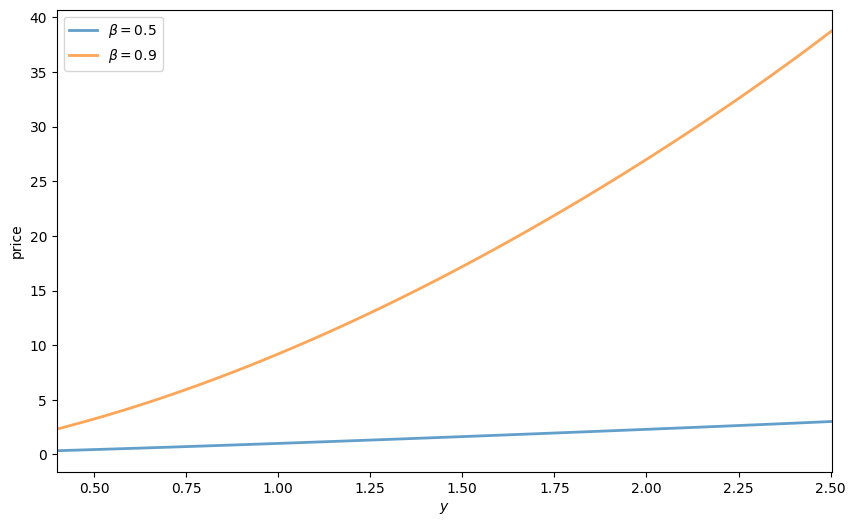

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

for β in (0.5, 0.9):
    tree = LucasTree(β=β)
    grid = tree.grid
    price_vals = solve_model(tree)
    label = rf'$\beta = {round(β, 3)}$'
    ax.plot(grid, price_vals, lw=2, alpha=0.7, label=label)

ax.legend(loc='upper left')
ax.set(xlabel='$y$', ylabel='price', xlim=(min(grid), max(grid)))
plt.show()

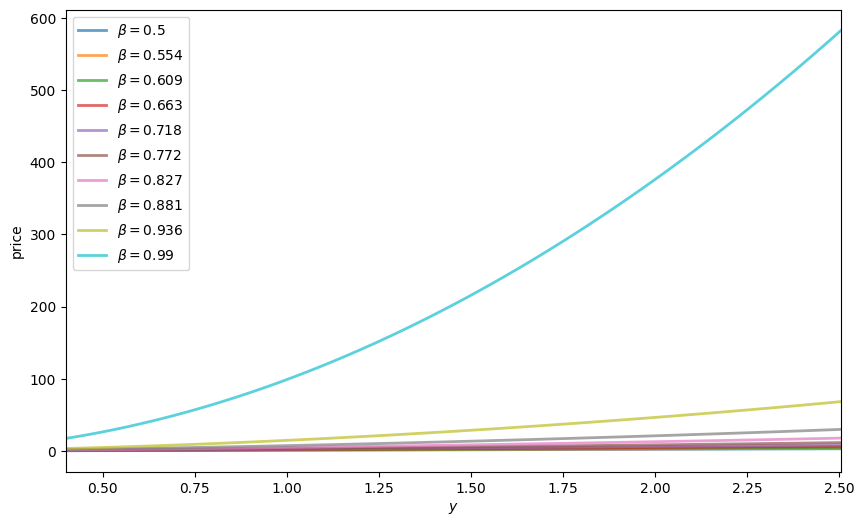

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

for β in np.linspace(0.5, 0.99, 10):
    tree = LucasTree(β=β)
    grid = tree.grid
    price_vals = solve_model(tree)
    label = rf'$\beta = {round(β, 3)}$'
    ax.plot(grid, price_vals, lw=2, alpha=0.7, label=label)

ax.legend(loc='upper left')
ax.set(xlabel='$y$', ylabel='price', xlim=(min(grid), max(grid)))
plt.show()